In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys
sys.path.append('../')
import default_style

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,happy,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.061167,2.701833,[5.9604645e-08 9.2448331e-02 7.0120022e-02 ......,[5.9604645e-08 9.2448264e-02 7.0119813e-02 ......,0,1304,2464,3832,4680,5664,6488,9840
1,speech,calm,strong,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.020167,2.983000,[3.3713877e-07 6.0990662e-03 8.3317356e-03 ......,[3.3713877e-07 6.0990625e-03 8.3317189e-03 ......,0,2112,5664,6304,6840,7704,9304,11776
2,speech,fearful,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.057000,2.642500,[4.5448542e-07 2.2871135e-02 2.1308422e-02 ......,[4.5448542e-07 2.2871116e-02 2.1308355e-02 ......,0,2032,3168,4648,5800,6728,7400,9512
3,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,928,1984,3232,4120,5120,5808,7352
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2104,3672,4808,5928,6944,7600,9056


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

# SORRY PAOLINO BUT I HAVE A CHICCO PC AND I CANNOT LOAD IT ALL

# for file in files:

#     if file.endswith('.npy'):
#         file_path = os.path.join(TS_PREPROC_FOLDER, file)
#         # dictionary keys are the file names
#         key = os.path.splitext(file)[0]
#         # load array
#         traces_dict[key] = np.load(file_path, allow_pickle=True)

# traces_dict.keys()

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)


In [5]:
traces = traces_dict[TRACES]
traces.shape

(2452, 23, 23)

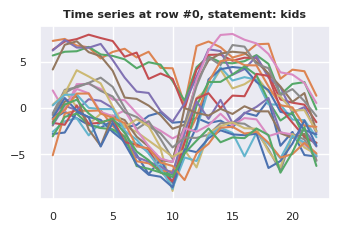

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

In [7]:
# sort by actors
sorted_indices = df['actor'].argsort()
df = df.iloc[sorted_indices].reset_index(drop=True)

traces = traces[sorted_indices]

# traces

In [8]:
from sklearn.model_selection import train_test_split

split_index = df[df['actor'] == 'actor_19'].index[0]

X_train = traces[:split_index]
X_test = traces[split_index:]

y_train = df[TARGET][:split_index].to_numpy()
y_test = df[TARGET][split_index:].to_numpy()

X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

X_train_v.shape, X_valid.shape, X_test.shape, y_train_v.shape, y_valid.shape, y_test.shape

((1462, 23, 23), (366, 23, 23), (624, 23, 23), (1462,), (366,), (624,))

# CNN

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_train_v = label_encoder.transform(y_train_v)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

y_valid[0]

0

In [10]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

def build_and_fit_cnn(X=X_train, y=y_train,
                      n_conv=0, n_hidden=0, hidden_nodes=32,
                      dropout=0.01, filters=8, kernel_size=5, batch_size=16,
                      epochs=32, validation_split=0., verbose=False):

    n_timesteps = X.shape[1]
    n_outputs = len(np.unique(y))
    n_features = X.shape[2]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_split=validation_split)

    return model

2023-06-26 12:33:12.177586: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 12:33:12.260448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 12:33:12.262045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 12:33:14.140438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
# Test to check the accuracy of a "belly" network
test_model = build_and_fit_cnn(n_conv=2, n_hidden=3, hidden_nodes=256, epochs=8, verbose=True)

Epoch 1/8
115/115 [==============================] - 6s 9ms/step - loss: 0.4668 - accuracy: 0.7653
Epoch 2/8
115/115 [==============================] - 1s 9ms/step - loss: 0.2290 - accuracy: 0.9097
Epoch 3/8
115/115 [==============================] - 1s 8ms/step - loss: 0.1656 - accuracy: 0.9305
Epoch 4/8
115/115 [==============================] - 1s 7ms/step - loss: 0.1181 - accuracy: 0.9535
Epoch 5/8
115/115 [==============================] - 1s 8ms/step - loss: 0.1268 - accuracy: 0.9551
Epoch 6/8
115/115 [==============================] - 1s 7ms/step - loss: 0.0993 - accuracy: 0.9650
Epoch 7/8
115/115 [==============================] - 1s 7ms/step - loss: 0.0910 - accuracy: 0.9688
Epoch 8/8
115/115 [==============================] - 1s 7ms/step - loss: 0.0875 - accuracy: 0.9677


In [12]:
# objective function to be minimized
def objective_fun(trial):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 1)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_and_fit_cnn(X=X_train_v,
                            y=y_train_v,
                            n_hidden=n_hidden,
                            hidden_nodes=hidden_nodes,
                            n_conv=n_conv,
                            dropout=dropout,
                            filters=filters,
                            kernel_size=kernel_size,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=False
                           )

    y_pred = np.argmax(cnn.predict(X_valid), axis=1)

    error = accuracy_score(y_valid, y_pred)

    return error


study = optuna.create_study(direction='maximize')
study.optimize(objective_fun, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-26 12:33:28,355] A new study created in memory with name: no-name-3c7c23e7-79cb-4c89-ac58-92c45b44f6df


Running little bitch having n_conv=3, dropout=0.9414931102510006, hidden_nodes=79
Running little bitch having n_conv=0, dropout=0.31513721378862014, hidden_nodes=145
Running little bitch having n_conv=1, dropout=0.3570974101760761, hidden_nodes=210
Running little bitch having n_conv=2, dropout=0.009969487582548564, hidden_nodes=173


[W 2023-06-26 12:33:28,705] Trial 0 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 79, 'dropout': 0.9414931102510006, 'filters': 9, 'kernel_size': 14, 'batch_size': 43, 'epochs': 83} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/home

Running little bitch having n_conv=1, dropout=0.14673641028961548, hidden_nodes=172
Running little bitch having n_conv=0, dropout=0.7944939808563942, hidden_nodes=19
Running little bitch having n_conv=3, dropout=0.024679104090898685, hidden_nodes=15


[W 2023-06-26 12:33:29,140] Trial 4 failed with parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 172, 'dropout': 0.14673641028961548, 'filters': 9, 'kernel_size': 15, 'batch_size': 31, 'epochs': 16} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=0, dropout=0.6106496066541305, hidden_nodes=112
Running little bitch having n_conv=0, dropout=0.7355594379820543, hidden_nodes=30
12/12 [==============================] - 1s 8ms/step


[I 2023-06-26 12:33:52,572] Trial 1 finished with value: 0.9781420765027322 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 145, 'dropout': 0.31513721378862014, 'filters': 15, 'kernel_size': 11, 'batch_size': 50, 'epochs': 40}. Best is trial 1 with value: 0.9781420765027322.


Running little bitch having n_conv=1, dropout=0.04504333581731257, hidden_nodes=66
12/12 [==============================] - 1s 9ms/step


[I 2023-06-26 12:33:56,945] Trial 8 finished with value: 0.9699453551912568 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 30, 'dropout': 0.7355594379820543, 'filters': 6, 'kernel_size': 8, 'batch_size': 60, 'epochs': 61}. Best is trial 1 with value: 0.9781420765027322.


Running little bitch having n_conv=0, dropout=0.27547850146663333, hidden_nodes=247
12/12 [==============================] - 0s 8ms/step


[I 2023-06-26 12:34:00,743] Trial 5 finished with value: 0.9754098360655737 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 19, 'dropout': 0.7944939808563942, 'filters': 7, 'kernel_size': 11, 'batch_size': 23, 'epochs': 33}. Best is trial 1 with value: 0.9781420765027322.


Running little bitch having n_conv=2, dropout=0.6547252771536956, hidden_nodes=218
12/12 [==============================] - 1s 9ms/step


[I 2023-06-26 12:34:10,345] Trial 9 finished with value: 0.9562841530054644 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 66, 'dropout': 0.04504333581731257, 'filters': 16, 'kernel_size': 10, 'batch_size': 55, 'epochs': 8}. Best is trial 1 with value: 0.9781420765027322.


Running little bitch having n_conv=1, dropout=0.4669060174622238, hidden_nodes=135


[W 2023-06-26 12:34:10,761] Trial 12 failed with parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 135, 'dropout': 0.4669060174622238, 'filters': 2, 'kernel_size': 14, 'batch_size': 35, 'epochs': 31} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 2] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.4837912012543141, hidden_nodes=236


[W 2023-06-26 12:34:11,063] Trial 13 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 236, 'dropout': 0.4837912012543141, 'filters': 7, 'kernel_size': 14, 'batch_size': 31, 'epochs': 45} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=0, dropout=0.15107627552047387, hidden_nodes=62
12/12 [==============================] - 0s 9ms/step


[I 2023-06-26 12:34:25,418] Trial 10 finished with value: 0.9726775956284153 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 247, 'dropout': 0.27547850146663333, 'filters': 8, 'kernel_size': 6, 'batch_size': 61, 'epochs': 51}. Best is trial 1 with value: 0.9781420765027322.


Running little bitch having n_conv=2, dropout=0.982671850227596, hidden_nodes=54
12/12 [==============================] - 0s 9ms/step


[I 2023-06-26 12:34:33,789] Trial 14 finished with value: 0.9836065573770492 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 62, 'dropout': 0.15107627552047387, 'filters': 12, 'kernel_size': 10, 'batch_size': 16, 'epochs': 21}. Best is trial 14 with value: 0.9836065573770492.


Running little bitch having n_conv=0, dropout=0.1821586301655992, hidden_nodes=174
 9/12 [=====================>........] - ETA: 0s

[I 2023-06-26 12:34:42,109] Trial 7 finished with value: 0.9617486338797814 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 112, 'dropout': 0.6106496066541305, 'filters': 4, 'kernel_size': 9, 'batch_size': 19, 'epochs': 87}. Best is trial 14 with value: 0.9836065573770492.


12/12 [==============================] - 1s 14ms/step
Running little bitch having n_conv=3, dropout=0.3533578662840742, hidden_nodes=24


[I 2023-06-26 12:34:42,226] Trial 11 finished with value: 0.9726775956284153 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 218, 'dropout': 0.6547252771536956, 'filters': 6, 'kernel_size': 8, 'batch_size': 60, 'epochs': 73}. Best is trial 14 with value: 0.9836065573770492.


Running little bitch having n_conv=3, dropout=0.8514452938688089, hidden_nodes=32


[W 2023-06-26 12:34:42,959] Trial 18 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 32, 'dropout': 0.8514452938688089, 'filters': 9, 'kernel_size': 8, 'batch_size': 29, 'epochs': 51} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 2, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/home/

Running little bitch having n_conv=1, dropout=0.6046082362177693, hidden_nodes=179
12/12 [==============================] - 1s 11ms/step


[I 2023-06-26 12:34:56,158] Trial 16 finished with value: 0.9836065573770492 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 174, 'dropout': 0.1821586301655992, 'filters': 12, 'kernel_size': 12, 'batch_size': 60, 'epochs': 31}. Best is trial 14 with value: 0.9836065573770492.


Running little bitch having n_conv=2, dropout=0.5256276730945134, hidden_nodes=37


[W 2023-06-26 12:34:56,468] Trial 20 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 37, 'dropout': 0.5256276730945134, 'filters': 4, 'kernel_size': 15, 'batch_size': 22, 'epochs': 41} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 4] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/home

Running little bitch having n_conv=2, dropout=0.13465002965172845, hidden_nodes=146


[W 2023-06-26 12:34:56,786] Trial 21 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 146, 'dropout': 0.13465002965172845, 'filters': 6, 'kernel_size': 15, 'batch_size': 30, 'epochs': 5} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/hom

Running little bitch having n_conv=1, dropout=0.33856303358615725, hidden_nodes=137
12/12 [==============================] - 1s 9ms/step


[I 2023-06-26 12:35:13,253] Trial 22 finished with value: 0.8825136612021858 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 137, 'dropout': 0.33856303358615725, 'filters': 9, 'kernel_size': 3, 'batch_size': 53, 'epochs': 9}. Best is trial 14 with value: 0.9836065573770492.


Running little bitch having n_conv=3, dropout=0.8987573588099101, hidden_nodes=86


[W 2023-06-26 12:35:13,774] Trial 23 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 86, 'dropout': 0.8987573588099101, 'filters': 12, 'kernel_size': 15, 'batch_size': 31, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9720086005171996, hidden_nodes=85


[W 2023-06-26 12:35:14,386] Trial 25 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 80, 'dropout': 0.9683722684597732, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 20} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9683722684597732, hidden_nodes=80


[W 2023-06-26 12:35:14,673] Trial 26 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 78, 'dropout': 0.9220455911044024, 'filters': 12, 'kernel_size': 16, 'batch_size': 33, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9220455911044024, hidden_nodes=78


[W 2023-06-26 12:35:14,965] Trial 27 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 80, 'dropout': 0.474424574823738, 'filters': 12, 'kernel_size': 14, 'batch_size': 32, 'epochs': 21} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.474424574823738, hidden_nodes=80


[W 2023-06-26 12:35:15,258] Trial 28 failed with parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 71, 'dropout': 0.9412677307280072, 'filters': 13, 'kernel_size': 16, 'batch_size': 31, 'epochs': 22} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=2, dropout=0.9412677307280072, hidden_nodes=71


[W 2023-06-26 12:35:15,566] Trial 29 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 79, 'dropout': 0.014447378514221343, 'filters': 12, 'kernel_size': 16, 'batch_size': 32, 'epochs': 22} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.014447378514221343, hidden_nodes=79


[W 2023-06-26 12:35:15,842] Trial 30 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 91, 'dropout': 0.9077257517020328, 'filters': 12, 'kernel_size': 15, 'batch_size': 31, 'epochs': 22} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9077257517020328, hidden_nodes=91


[W 2023-06-26 12:35:16,113] Trial 31 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 80, 'dropout': 0.4865169437145476, 'filters': 12, 'kernel_size': 16, 'batch_size': 31, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.4865169437145476, hidden_nodes=80


[W 2023-06-26 12:35:16,392] Trial 32 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 72, 'dropout': 0.018432772164167832, 'filters': 12, 'kernel_size': 16, 'batch_size': 31, 'epochs': 21} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.018432772164167832, hidden_nodes=72


[W 2023-06-26 12:35:16,703] Trial 33 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 74, 'dropout': 0.9267608122093588, 'filters': 12, 'kernel_size': 16, 'batch_size': 31, 'epochs': 21} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9267608122093588, hidden_nodes=74


[W 2023-06-26 12:35:16,986] Trial 34 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 83, 'dropout': 0.9797243768241132, 'filters': 12, 'kernel_size': 16, 'batch_size': 33, 'epochs': 21} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9797243768241132, hidden_nodes=83
Running little bitch having n_conv=3, dropout=0.9778796033050652, hidden_nodes=90


[W 2023-06-26 12:35:17,321] Trial 35 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 90, 'dropout': 0.9778796033050652, 'filters': 12, 'kernel_size': 16, 'batch_size': 31, 'epochs': 22} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.9841139583450426, hidden_nodes=84
Running little bitch having n_conv=3, dropout=0.0006059246883597658, hidden_nodes=78


[W 2023-06-26 12:35:18,077] Trial 37 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 78, 'dropout': 0.0006059246883597658, 'filters': 12, 'kernel_size': 16, 'batch_size': 31, 'epochs': 21} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.005519007375072549, hidden_nodes=76
12/12 [==============================] - 1s 8ms/step


[W 2023-06-26 12:35:18,467] Trial 38 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 76, 'dropout': 0.005519007375072549, 'filters': 12, 'kernel_size': 16, 'batch_size': 32, 'epochs': 21} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.9791708919052526, hidden_nodes=78
Running little bitch having n_conv=3, dropout=0.003056337726812297, hidden_nodes=84


[W 2023-06-26 12:35:18,985] Trial 39 failed with parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 78, 'dropout': 0.9791708919052526, 'filters': 12, 'kernel_size': 16, 'batch_size': 30, 'epochs': 22} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/ho

Running little bitch having n_conv=3, dropout=0.016420489181118936, hidden_nodes=80
Running little bitch having n_conv=3, dropout=0.11916463044475643, hidden_nodes=84


[W 2023-06-26 12:35:19,535] Trial 41 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 80, 'dropout': 0.016420489181118936, 'filters': 12, 'kernel_size': 15, 'batch_size': 30, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.061588090751146976, hidden_nodes=90
Running little bitch having n_conv=3, dropout=0.03428714903371766, hidden_nodes=87


[W 2023-06-26 12:35:20,061] Trial 43 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 90, 'dropout': 0.061588090751146976, 'filters': 12, 'kernel_size': 15, 'batch_size': 31, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.0010342873830901933, hidden_nodes=86
Running little bitch having n_conv=3, dropout=0.026102610842110074, hidden_nodes=93


[W 2023-06-26 12:35:20,603] Trial 46 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 93, 'dropout': 0.026102610842110074, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.05273495922732052, hidden_nodes=82
Running little bitch having n_conv=3, dropout=0.04395108128294062, hidden_nodes=84


[W 2023-06-26 12:35:21,108] Trial 47 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 82, 'dropout': 0.05273495922732052, 'filters': 12, 'kernel_size': 16, 'batch_size': 30, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.06569531750297201, hidden_nodes=87
Running little bitch having n_conv=3, dropout=0.06643542648270284, hidden_nodes=87


[W 2023-06-26 12:35:21,692] Trial 49 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 87, 'dropout': 0.06643542648270284, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.018526454281520277, hidden_nodes=82
Running little bitch having n_conv=3, dropout=0.04167879162644275, hidden_nodes=83


[W 2023-06-26 12:35:22,226] Trial 51 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 83, 'dropout': 0.04167879162644275, 'filters': 12, 'kernel_size': 14, 'batch_size': 32, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.003435254935058474, hidden_nodes=81
Running little bitch having n_conv=3, dropout=0.08077732033539906, hidden_nodes=83


[W 2023-06-26 12:35:22,757] Trial 53 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 81, 'dropout': 0.003435254935058474, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.058825306749048095, hidden_nodes=90
Running little bitch having n_conv=3, dropout=0.0026715121812834752, hidden_nodes=89


[W 2023-06-26 12:35:23,315] Trial 56 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 89, 'dropout': 0.0026715121812834752, 'filters': 12, 'kernel_size': 14, 'batch_size': 34, 'epochs': 19} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File 

Running little bitch having n_conv=3, dropout=0.03178018259420118, hidden_nodes=73Running little bitch having n_conv=2, dropout=0.08748585943786169, hidden_nodes=93



[W 2023-06-26 12:35:23,833] Trial 57 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 93, 'dropout': 0.08748585943786169, 'filters': 12, 'kernel_size': 16, 'batch_size': 32, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.08762845217192766, hidden_nodes=85
Running little bitch having n_conv=3, dropout=0.02640698106062589, hidden_nodes=92


[W 2023-06-26 12:35:24,320] Trial 59 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 85, 'dropout': 0.08762845217192766, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.024438912988920536, hidden_nodes=97
Running little bitch having n_conv=3, dropout=0.02299278133980151, hidden_nodes=78


[W 2023-06-26 12:35:24,845] Trial 61 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 97, 'dropout': 0.024438912988920536, 'filters': 12, 'kernel_size': 15, 'batch_size': 38, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.004861126667604465, hidden_nodes=84
Running little bitch having n_conv=2, dropout=0.026530271304983366, hidden_nodes=92


[W 2023-06-26 12:35:25,376] Trial 64 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 92, 'dropout': 0.026530271304983366, 'filters': 12, 'kernel_size': 16, 'batch_size': 34, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.018886947178507474, hidden_nodes=80
Running little bitch having n_conv=3, dropout=0.013210882113690647, hidden_nodes=96


[W 2023-06-26 12:35:25,928] Trial 65 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 80, 'dropout': 0.018886947178507474, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.06796048192395326, hidden_nodes=88
Running little bitch having n_conv=3, dropout=0.005647548877098618, hidden_nodes=79


[W 2023-06-26 12:35:26,433] Trial 67 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 88, 'dropout': 0.06796048192395326, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.05027520505377478, hidden_nodes=80
Running little bitch having n_conv=3, dropout=0.022884962773734363, hidden_nodes=84


[W 2023-06-26 12:35:26,967] Trial 69 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 84, 'dropout': 0.022884962773734363, 'filters': 12, 'kernel_size': 16, 'batch_size': 32, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.01813236533509968, hidden_nodes=77
Running little bitch having n_conv=3, dropout=0.04194805128984347, hidden_nodes=82


[W 2023-06-26 12:35:27,483] Trial 72 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 77, 'dropout': 0.01813236533509968, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.033541021070295995, hidden_nodes=93
Running little bitch having n_conv=3, dropout=0.004892043844807625, hidden_nodes=82


[W 2023-06-26 12:35:27,998] Trial 73 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 93, 'dropout': 0.033541021070295995, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.02574512523296607, hidden_nodes=86


[W 2023-06-26 12:35:28,475] Trial 75 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 86, 'dropout': 0.02574512523296607, 'filters': 12, 'kernel_size': 16, 'batch_size': 35, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.04297176316888976, hidden_nodes=99


[W 2023-06-26 12:35:28,779] Trial 76 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 99, 'dropout': 0.04297176316888976, 'filters': 12, 'kernel_size': 15, 'batch_size': 35, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.012960580130602195, hidden_nodes=77


[W 2023-06-26 12:35:29,003] Trial 77 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 77, 'dropout': 0.012960580130602195, 'filters': 12, 'kernel_size': 14, 'batch_size': 32, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.06204214333861083, hidden_nodes=87


[W 2023-06-26 12:35:29,325] Trial 78 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 87, 'dropout': 0.06204214333861083, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=2, dropout=0.04751448281506865, hidden_nodes=89


[W 2023-06-26 12:35:29,520] Trial 79 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 89, 'dropout': 0.04751448281506865, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.02695222610561429, hidden_nodes=90
Running little bitch having n_conv=3, dropout=0.0023383476397080827, hidden_nodes=88


[W 2023-06-26 12:35:29,833] Trial 80 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 90, 'dropout': 0.02695222610561429, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=2, dropout=0.03529093513824333, hidden_nodes=81


[W 2023-06-26 12:35:30,364] Trial 82 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 81, 'dropout': 0.03529093513824333, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.0009700700866717704, hidden_nodes=85


[W 2023-06-26 12:35:30,603] Trial 83 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 85, 'dropout': 0.0009700700866717704, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.024212553939120363, hidden_nodes=75


[W 2023-06-26 12:35:30,876] Trial 84 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 75, 'dropout': 0.024212553939120363, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.030002267464738885, hidden_nodes=91


[W 2023-06-26 12:35:31,141] Trial 85 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 91, 'dropout': 0.030002267464738885, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.04033278480557881, hidden_nodes=83


[W 2023-06-26 12:35:31,455] Trial 86 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 83, 'dropout': 0.04033278480557881, 'filters': 12, 'kernel_size': 16, 'batch_size': 33, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.026644718811707657, hidden_nodes=80


[W 2023-06-26 12:35:31,651] Trial 87 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 80, 'dropout': 0.026644718811707657, 'filters': 12, 'kernel_size': 15, 'batch_size': 35, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.031009650690299317, hidden_nodes=79
Running little bitch having n_conv=3, dropout=0.03349384028575608, hidden_nodes=84


[W 2023-06-26 12:35:31,976] Trial 88 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 79, 'dropout': 0.031009650690299317, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.020162999876975007, hidden_nodes=100


[W 2023-06-26 12:35:32,523] Trial 90 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 100, 'dropout': 0.020162999876975007, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.006220005572180665, hidden_nodes=91


[W 2023-06-26 12:35:32,768] Trial 91 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 91, 'dropout': 0.006220005572180665, 'filters': 13, 'kernel_size': 15, 'batch_size': 33, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.006032487516568152, hidden_nodes=86


[W 2023-06-26 12:35:33,058] Trial 92 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 86, 'dropout': 0.006032487516568152, 'filters': 13, 'kernel_size': 15, 'batch_size': 34, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.01185795141399798, hidden_nodes=83


[W 2023-06-26 12:35:33,343] Trial 93 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 83, 'dropout': 0.01185795141399798, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.006038638700523624, hidden_nodes=83


[W 2023-06-26 12:35:33,571] Trial 94 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 83, 'dropout': 0.006038638700523624, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.01718823288536342, hidden_nodes=87
Running little bitch having n_conv=3, dropout=0.009687443004830626, hidden_nodes=99


[W 2023-06-26 12:35:33,909] Trial 95 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 87, 'dropout': 0.01718823288536342, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.004900832466236016, hidden_nodes=82
Running little bitch having n_conv=2, dropout=0.016886214018691753, hidden_nodes=87


[W 2023-06-26 12:35:34,461] Trial 97 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 82, 'dropout': 0.004900832466236016, 'filters': 12, 'kernel_size': 14, 'batch_size': 33, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.05266679809352917, hidden_nodes=71
Running little bitch having n_conv=3, dropout=0.004711050483479695, hidden_nodes=70


[W 2023-06-26 12:35:34,952] Trial 100 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 71, 'dropout': 0.05266679809352917, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.03532244772095505, hidden_nodes=96
Running little bitch having n_conv=3, dropout=0.025712732112179393, hidden_nodes=103


[W 2023-06-26 12:35:35,527] Trial 102 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 103, 'dropout': 0.025712732112179393, 'filters': 12, 'kernel_size': 16, 'batch_size': 33, 'epochs': 28} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File 

Running little bitch having n_conv=3, dropout=0.029940382257834852, hidden_nodes=90
Running little bitch having n_conv=3, dropout=0.10988622400233787, hidden_nodes=85


[W 2023-06-26 12:35:36,068] Trial 103 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 85, 'dropout': 0.10988622400233787, 'filters': 12, 'kernel_size': 15, 'batch_size': 31, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.010618329076139466, hidden_nodes=80
Running little bitch having n_conv=3, dropout=0.0005112850633155475, hidden_nodes=84


[W 2023-06-26 12:35:36,585] Trial 105 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 80, 'dropout': 0.010618329076139466, 'filters': 12, 'kernel_size': 16, 'batch_size': 34, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.04127111651066129, hidden_nodes=77
Running little bitch having n_conv=3, dropout=0.01679754133526995, hidden_nodes=91


[W 2023-06-26 12:35:37,224] Trial 108 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 91, 'dropout': 0.01679754133526995, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.0013579687237387783, hidden_nodes=81
Running little bitch having n_conv=3, dropout=0.00482215242899689, hidden_nodes=93


[W 2023-06-26 12:35:37,778] Trial 109 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 93, 'dropout': 0.00482215242899689, 'filters': 13, 'kernel_size': 15, 'batch_size': 34, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.9669444935466666, hidden_nodes=87
Running little bitch having n_conv=3, dropout=0.07316067918440974, hidden_nodes=81


[W 2023-06-26 12:35:38,405] Trial 111 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 87, 'dropout': 0.9669444935466666, 'filters': 12, 'kernel_size': 14, 'batch_size': 33, 'epochs': 27} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.03240981286542477, hidden_nodes=82
Running little bitch having n_conv=3, dropout=0.014834602040262601, hidden_nodes=88


[W 2023-06-26 12:35:38,924] Trial 114 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 82, 'dropout': 0.03240981286542477, 'filters': 12, 'kernel_size': 15, 'batch_size': 36, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.014650577733291259, hidden_nodes=80
Running little bitch having n_conv=3, dropout=0.00388247170497108, hidden_nodes=76


[W 2023-06-26 12:35:39,453] Trial 115 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 80, 'dropout': 0.014650577733291259, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.019303630417767503, hidden_nodes=83
Running little bitch having n_conv=3, dropout=0.022023715985553638, hidden_nodes=86


[W 2023-06-26 12:35:39,984] Trial 118 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 86, 'dropout': 0.022023715985553638, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.04057200396354249, hidden_nodes=86Running little bitch having n_conv=3, dropout=0.00959830403903239, hidden_nodes=77



[W 2023-06-26 12:35:40,634] Trial 120 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 77, 'dropout': 0.00959830403903239, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.000838380018971685, hidden_nodes=79
Running little bitch having n_conv=3, dropout=0.00239815806923227, hidden_nodes=87


[W 2023-06-26 12:35:41,408] Trial 121 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 79, 'dropout': 0.000838380018971685, 'filters': 12, 'kernel_size': 15, 'batch_size': 35, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.010542453179268718, hidden_nodes=88
Running little bitch having n_conv=3, dropout=0.06386082303001059, hidden_nodes=82


[W 2023-06-26 12:35:41,956] Trial 124 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 82, 'dropout': 0.06386082303001059, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 26} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=2, dropout=0.01676760957377449, hidden_nodes=86
Running little bitch having n_conv=3, dropout=0.007646382534517826, hidden_nodes=72


[W 2023-06-26 12:35:42,523] Trial 126 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 72, 'dropout': 0.007646382534517826, 'filters': 12, 'kernel_size': 15, 'batch_size': 36, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.015113339421001182, hidden_nodes=81
Running little bitch having n_conv=3, dropout=0.09247568875440294, hidden_nodes=69


[W 2023-06-26 12:35:43,144] Trial 128 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 69, 'dropout': 0.09247568875440294, 'filters': 12, 'kernel_size': 14, 'batch_size': 33, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 10, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.03568011215297637, hidden_nodes=100
Running little bitch having n_conv=3, dropout=0.06037980218833372, hidden_nodes=85


[W 2023-06-26 12:35:43,709] Trial 130 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 85, 'dropout': 0.06037980218833372, 'filters': 12, 'kernel_size': 15, 'batch_size': 36, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.001413246307937599, hidden_nodes=83
Running little bitch having n_conv=3, dropout=0.0056446937487904525, hidden_nodes=78


[W 2023-06-26 12:35:44,350] Trial 131 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 78, 'dropout': 0.0056446937487904525, 'filters': 12, 'kernel_size': 15, 'batch_size': 30, 'epochs': 20} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File 

Running little bitch having n_conv=3, dropout=0.01951267817279634, hidden_nodes=87
Running little bitch having n_conv=2, dropout=0.009430630153594632, hidden_nodes=84


[W 2023-06-26 12:35:45,212] Trial 134 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 87, 'dropout': 0.01951267817279634, 'filters': 12, 'kernel_size': 16, 'batch_size': 32, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.010145836729874819, hidden_nodes=83
Running little bitch having n_conv=3, dropout=0.003957312375457517, hidden_nodes=83


[W 2023-06-26 12:35:45,843] Trial 135 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 83, 'dropout': 0.010145836729874819, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 22} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.03909062689075948, hidden_nodes=83


[W 2023-06-26 12:35:46,444] Trial 137 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 83, 'dropout': 0.03909062689075948, 'filters': 12, 'kernel_size': 16, 'batch_size': 35, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 8, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.008790849960868236, hidden_nodes=88


[W 2023-06-26 12:35:46,734] Trial 138 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 88, 'dropout': 0.008790849960868236, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.1601709614001696, hidden_nodes=75


[W 2023-06-26 12:35:47,114] Trial 139 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 75, 'dropout': 0.1601709614001696, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 28} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/h

Running little bitch having n_conv=3, dropout=0.0004903983873540407, hidden_nodes=86


[W 2023-06-26 12:35:47,468] Trial 140 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 86, 'dropout': 0.0004903983873540407, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File 

Running little bitch having n_conv=3, dropout=0.044258011754547216, hidden_nodes=88
Running little bitch having n_conv=3, dropout=0.014640262267116538, hidden_nodes=95


[W 2023-06-26 12:35:47,861] Trial 141 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 88, 'dropout': 0.044258011754547216, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.013036257803855034, hidden_nodes=81


[W 2023-06-26 12:35:48,477] Trial 143 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 81, 'dropout': 0.013036257803855034, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.033453093446653925, hidden_nodes=88


[W 2023-06-26 12:35:48,714] Trial 144 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 88, 'dropout': 0.033453093446653925, 'filters': 12, 'kernel_size': 15, 'batch_size': 36, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.07117207967576175, hidden_nodes=86
Running little bitch having n_conv=3, dropout=0.033361450280502414, hidden_nodes=84


[W 2023-06-26 12:35:49,222] Trial 146 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 84, 'dropout': 0.033361450280502414, 'filters': 13, 'kernel_size': 15, 'batch_size': 34, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 13] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.04239633527729347, hidden_nodes=77


[W 2023-06-26 12:35:49,755] Trial 147 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 77, 'dropout': 0.04239633527729347, 'filters': 12, 'kernel_size': 15, 'batch_size': 33, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

Running little bitch having n_conv=3, dropout=0.034027399103017136, hidden_nodes=83


[W 2023-06-26 12:35:50,219] Trial 148 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 83, 'dropout': 0.034027399103017136, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 25} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 9, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "

Running little bitch having n_conv=3, dropout=0.0741120653143085, hidden_nodes=87


[W 2023-06-26 12:35:50,385] Trial 149 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 87, 'dropout': 0.0741120653143085, 'filters': 12, 'kernel_size': 13, 'batch_size': 34, 'epochs': 24} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 11, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22119/4273198217.py", line 15, in objective_fun
    cnn = build_and_fit_cnn(X=X_train_v,
  File "/tmp/ipykernel_22119/2256047732.py", line 28, in build_and_fit_cnn
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
  File "/

12/12 [==============================] - 1s 9ms/step


[I 2023-06-26 12:35:57,828] Trial 15 finished with value: 0.7404371584699454 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 54, 'dropout': 0.982671850227596, 'filters': 13, 'kernel_size': 4, 'batch_size': 20, 'epochs': 69}. Best is trial 14 with value: 0.9836065573770492.


12/12 [==============================] - 0s 4ms/step


[I 2023-06-26 12:36:00,854] Trial 17 finished with value: 0.953551912568306 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 24, 'dropout': 0.3533578662840742, 'filters': 16, 'kernel_size': 2, 'batch_size': 28, 'epochs': 62}. Best is trial 14 with value: 0.9836065573770492.


In [13]:
best_params = study.best_params
best_params

{'n_conv': 0,
 'n_hidden': 0,
 'hidden_nodes': 62,
 'dropout': 0.15107627552047387,
 'filters': 12,
 'kernel_size': 10,
 'batch_size': 16,
 'epochs': 21}

In [14]:
cnn = build_and_fit_cnn(**best_params)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 14, 12)            2772      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 12)           48        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 14, 12)            0         
                                                                 
 global_average_pooling1d_1   (None, 12)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 2)                 26        
                                                                 
Total params: 2,846
Trainable params: 2,822
Non-traina

In [15]:
from sklearn.metrics import f1_score, classification_report

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 3ms/step
Accuracy 0.9791666666666666
F1-score [0.97899838 0.97933227]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       312
           1       0.97      0.99      0.98       312

    accuracy                           0.98       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.98      0.98      0.98       624

